# MIP Robot Locomotion

## Preliminaries

The next lines setup some things and import the various libraries required to run this notebook.

Don't forget to initialize the server with:

    sudo pyctrl_start_server -m pyctrl.rc.drive


In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import math
import time

from pyctrl.block import ShortCircuit
from pyctrl.block.system import Differentiator, Gain
from pyctrl.block import Interp, Logger, Constant

from pyctrl.client import Controller
HOST, PORT = "192.168.8.1", 9999
mip = Controller(host = HOST, port = PORT)

mip.reset()
print(mip.info('all'))

<class 'pyctrl.rc.drive.Controller'> with:
  0 timer(s), 10 signal(s),
  4 source(s), 0 filter(s), and 2 sink(s)
> timers
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. is_running
  6. pitch
  7. pwm1
  8. pwm2
  9. roll
  10. yaw
> sources
  1. clock[MPU9250, enabled] >> clock
  2. orientation[TaitBryanAngles, enabled] >> pitch, roll, yaw
  3. encoder1[Encoder, enabled] >> encoder1
  4. encoder2[Encoder, enabled] >> encoder2
> filters
> sinks
  1. pwm1 >> motor1[Motor, disabled]
  2. pwm2 >> motor2[Motor, disabled]



<a id='straight'></a>
## Driving on a straight line


Write python code to perform the following tasks with your wheeled MIP:

### Tasks:

1.  Set the signal `pwm1` = 50% and `pmw2` = 50% during 2 seconds. Plot
    the response of both `encoder1` and `encoder2`. Plot also the
    encoder velocities.
2.  Repeat the experiment with `pwm1` = `pwm2` = 30%
3.  Repeat the experiment with `pwm1` = `pwm2` = 15%
4.  Repeat the experiment with `pwm1` = `pwm2` = 5%

### Questions

1.  What is the relationship between the value of the `pwm` signals and
    the values of `encoder`s?
2.  What is the relationship between the value of the `pwm` signals and
    the values of the encoder `velocities`?

In [4]:
mip.set_signal('pwm1', 30)
mip.set_signal('pwm2', 30)
with mip:
    time.sleep(2)

## A simple model for straight motion

You will now create the following input signal that can vary the values of `pwm1` and `pwm2` continuously, represented by the following points:

In [5]:
# build interpolated input signal
M = 40
ts = np.array([0, 1,3, 4])*4
us = [0, M, -M, 0]
T = ts[-1]
N = 4

a plot of which looks like:

<IPython.core.display.Javascript object>


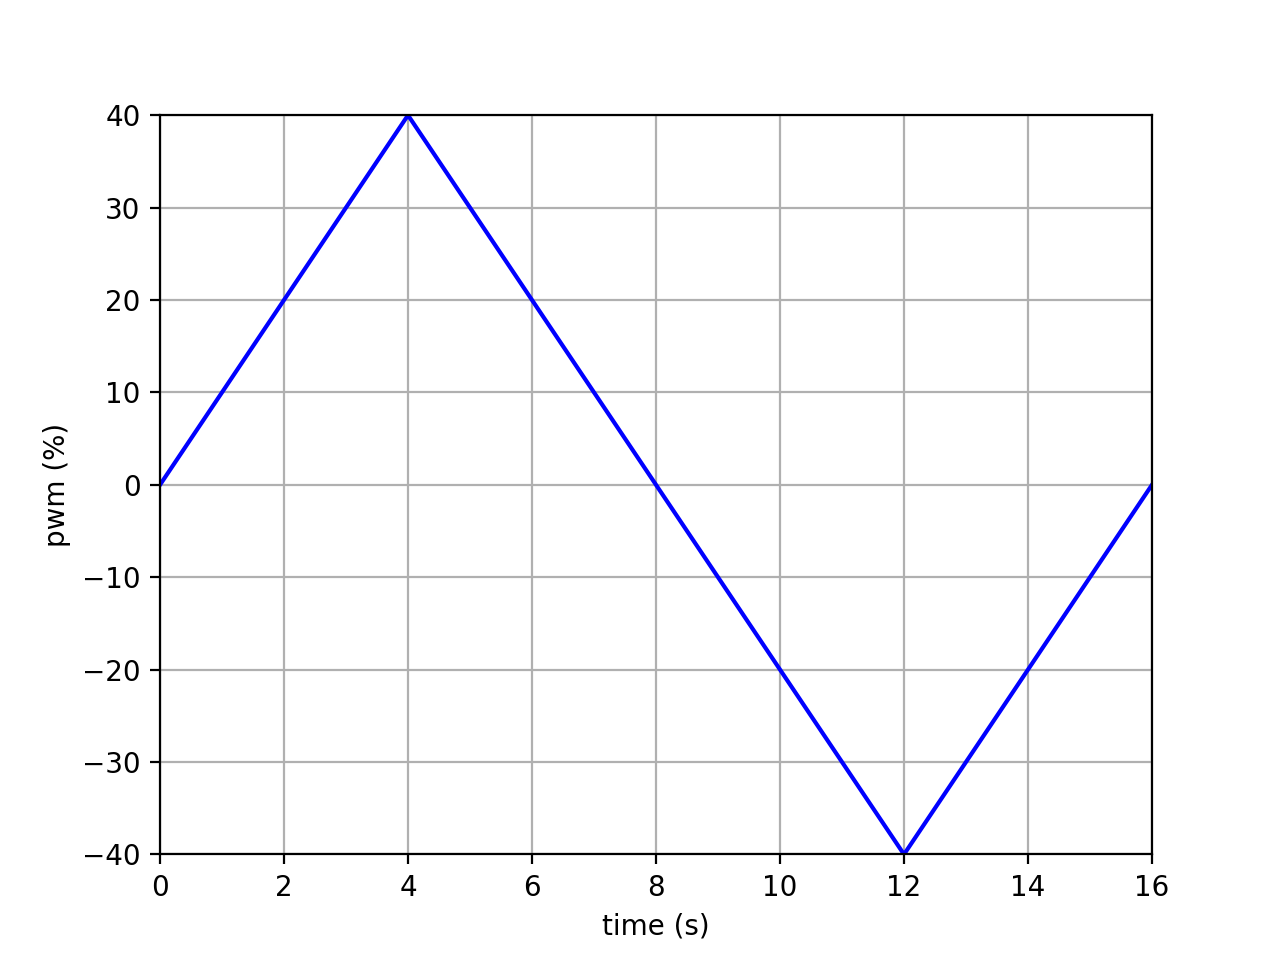

In [6]:
# start plot
plt.figure()

# plot input
plt.plot(ts, us, 'b')
plt.ylabel('pwm (%)')
plt.xlabel('time (s)')
plt.ylim((-M,M))
plt.xlim(0,T)
plt.grid()

The following code will use the block *Interp* to apply this signal to both `pwm1` and `pwm2` and repeat 4 times:

In [ ]:
# add pwm signal
mip.add_signal('pwm')

# add filter to interpolate data
mip.add_filter('input',
                Interp(xp = us, fp = ts, period = T),
                ['clock'],
                ['pwm'])

# connect pwm to two motors
mip.add_filter('pwm1',
                ShortCircuit(),
                ['pwm'],
                ['pwm1'])
mip.add_filter('pwm2',
                ShortCircuit(),
                ['pwm'],
                ['pwm2'])

# add differentiators
mip.add_signals('velocity1','velocity2')
mip.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
mip.add_filter('velocity2', Differentiator(), ['clock', 'encoder2'],['velocity2'])

# add logger
mip.add_sink('logger', Logger(auto_reset = True), ['clock', 'encoder1', 'encoder2', 'velocity1', 'velocity2','pwm'])

# add a timer to stop the controller
mip.add_timer('stop',
               Constant(value = 0),
               None, ['is_running'],
               period = N * T, repeat = False)

print(mip.info('all'))

Run the MIP until the signal repeats 4 times.

In [ ]:
with mip:
    mip.join()

Retrieve and plot the data

In [ ]:
log = mip.get_sink('logger','log')

In [ ]:
plt.figure()
plt.plot(log['clock'], log['velocity1'], log['clock'], log['velocity2'])
plt.xlabel('t (s)')
plt.ylabel('velocity (cycles)')
plt.grid()

In [ ]:
plt.figure()
plt.plot(log['pwm'], log['velocity1'],'b.',
         log['pwm'], log['velocity2'],'g.')
plt.xlabel('pwm (%)')
plt.ylabel('velocity (cycles)')
plt.grid()

You will now fit the data to lines

In [ ]:
def func(x, a, b):
    return a * x + b

import scipy.optimize as optimize

ind = np.where((log['pwm'] > 0) & (log['velocity1'] > 0))
pars, residues = optimize.curve_fit(func, log['pwm'][ind], log['velocity1'][ind])
a1p,b1p = pars.tolist()
print('v1 > 0: a = {:4.3f}, b = {:4.3f}'.format(a1p,b1p))

ind = np.where((log['pwm'] > 0) & (log['velocity2'] > 0))
pars, residues = optimize.curve_fit(func, log['pwm'][ind], log['velocity2'][ind])
a2p,b2p = pars.tolist()
print('v2 > 0: a = {:4.3f}, b = {:4.3f}'.format(a2p,b2p))

ind = np.where((log['pwm'] < 0) & (log['velocity1'] < 0))
pars, residues = optimize.curve_fit(func, log['pwm'][ind], log['velocity1'][ind])
a1n,b1n = pars.tolist()
print('v1 < 0: a = {:4.3f}, b = {:4.3f}'.format(a1n,b1n))

ind = np.where((log['pwm'] < 0) & (log['velocity2'] < 0))
pars, residues = optimize.curve_fit(func, log['pwm'][ind], log['velocity2'][ind])
a2n,b2n = pars.tolist()
print('v2 < 0: a = {:4.3f}, b = {:4.3f}'.format(a2n,b2n))

Plot fitted curves with the data:

In [ ]:
plt.figure()
plt.plot(log['pwm'], log['velocity1'],'b.',
         [0, M], [b1p, a1p*M + b1p], 'r-',
         [-M,0], [-a1n*M + b1n, b1n], 'r-')
plt.xlabel('pwm (%)')
plt.ylabel('velocity (cycles)')
plt.grid()

In [ ]:
plt.figure()
plt.plot(log['pwm'], log['velocity2'],'g.',
         [0, M], [b2p, a2p*M + b2p], 'y-',
         [-M,0], [-a2n*M + b2n, b2n], 'y-')
plt.xlabel('pwm (%)')
plt.ylabel('velocity (cycles)')
plt.grid()

### Tasks

1. Use the above model to calculate the values of `pwm1` and `pwm2` for the MIP to move on a straight line with an angular velocity of 2 Hz.
2. Run the MIP at that velocity and compare the predicted result with the experiment.
3. For what values of `pwm` does the MIP not move at all?
4. What is the meaning of the parameters `a` and `b` in the above line fit?

<a id='circles'></a>
## Driving in circles

Write python code to perform the following tasks with your wheeled MIP:

### Tasks:

1.  Set the signal `pwm1` = 50% and `pmw2` = 25% during 3 seconds. Plot
    the response of both `encoder1` and `encoder2`. Plot also the
    encoder velocities.
2.  Repeat the experiment with `pwm1` = 50% and `pmw2` = 15%.
3.  Repeat the experiment with `pwm1` = 50% and `pmw2` = 0%.

### Questions

1.  What is the geometry of the trajectory of the robot in each case?
2.  What is the relation between the value of the `pwm` signals and the movement of the robot?
3.  Is there any direction in which the robot cannot move toward?


## How does a two-wheeled robot move?

If a two-wheeled robot is moving in a circle of radius $R$ and $\ell$ is
the distance between the center of the robot axle and each wheel then

$$v_r = \omega \, (R + \ell/2), \quad 
  v_l = \omega \, (R - \ell/2)$$

where $v_l$ is the velocity of the *left* wheel, and $v_r$ is the
velocity of the *right* wheel.

### Questions

1. Show that:

   $$R = \frac{\ell}{2} \frac{v_r + v_l}{v_r - v_l}, \quad \omega = \frac{v_r - v_l}{\ell}$$

2. What does the quantity:

   $$v = \omega \, R = \frac{v_r + v_l}{2}$$
    
   correspond to?

3. What happens when:
   1. $v_r > v_l > 0$
   2. $0 < v_r < v_l$
   3. $v_r = v_l$
   4. $v_r = 0$ or $v_l = 0$

4.  What is the effect of $\ell$ on the movement of the robot?
5.  Why would you choose a robot with a little $\ell$?
6.  Why would you choose a robot with a big $\ell$?
7.  How different is the movement of your robot from that of a regular car?

Now let $r$ be the radius of both left and right wheels and $\omega_l$ and
$\omega_r$ be the wheels' angular speed.

### Questions

1.  Show that:

    $$R = \frac{\ell}{2} \frac{\omega_r + \omega_l}{\omega_r - \omega_l}, \quad \omega = \frac{r}{\ell} (\omega_r - \omega_l)$$

2.  Show that:

    $$v = \omega \, R = \frac{r}{2} (\omega_r + \omega_l)$$

3.  What happens when:
    1.   $\omega_r = \omega_l$
    2.   $\omega_r = - \omega_l$
    3.   $\omega_r = 0$ or $\omega_l = 0$

Since $R$ can be very large, it is often more convenient to work with the *curvature*:

$$\kappa = R^{-1} = \frac{2}{\ell} \frac{\omega_r - \omega_l}{\omega_r + \omega_l}$$.

### Tasks

1. Repeat the experiments with the MIP you performed [above](#circles), this time calculating
   and plotting the radius $R$ and the curvature $\kappa$ and the angular velocity $\omega$.

## Testing your model with circular motion

You will now create the following input signals that can vary the values of `pwm1` and `pwm2` continuously, represented by the following points:

In [ ]:
# build interpolated input signals
m = 20
M = 40
ts = np.array([0, 1, 2, 3, 4])*4
us1 = [(m+M)/2, M, (m+M)/2, m, (m+M)/2]
us2 = [M, (m+M)/2, m, (m+M)/2,M]
T = ts[-1]
N = 1

a plot of which looks like:

In [ ]:
# start plot
plt.figure()

# plot input
plt.plot(ts, us1, ts, us2)
plt.ylabel('pwm (%)')
plt.xlabel('time (s)')
plt.ylim((0,M))
plt.xlim(0,T)
plt.grid()

### Tasks

1. Write a Python program that uses the model obtained above to predict the angular velocity of the left and right wheels, $\omega_l$ and $\omega_r$, for the above `pwm` inputs.
2. Write a Python program that uses the model obtained above to predict the curvature, $\kappa$, the angular velocity $\omega$, and the forward velocity, $v$, for the above `pwm` inputs.
3. Plot the prected velocities and curvature.

In [ ]:
# SOLUTION

r = 0.034
l = 0.072

t = np.linspace(0, T, 200)
u1 = np.interp(t, ts, us1)
u2 = np.interp(t, ts, us2)

v1 = (a1p*u1 + b1p)
v2 = (a2p*u2 + b2p)

w1 = 2*np.pi*v1
w2 = 2*np.pi*v2

kappa = (2/l)*(w1/w2-1)/(w1/w2+1)
v = (r/2)*(w1 + w2)
w = (r/l)*(w1 - w2)

In [ ]:
# start plot
plt.figure()

# plot input
plt.plot(t, w1, t, w2)
plt.ylabel('w (rad/s)')
plt.xlabel('time (s)')
plt.grid()

In [ ]:
# start plot
plt.figure()

# plot input
plt.plot(t, kappa)
plt.ylabel('kappa (1/m)')
plt.xlabel('time (s)')
plt.grid()

In [ ]:
# start plot
plt.figure()

# plot input
plt.plot(t, w)
plt.ylabel('$\omega$ (rad/s)')
plt.xlabel('time (s)')
plt.grid()

In [ ]:
# start plot
plt.figure()

# plot input
plt.plot(t, v)
plt.ylabel('$v$ (m/s)')
plt.xlabel('time (s)')
plt.grid()

Apply the signal to the MIP:

In [ ]:
# add pwm signal
mip.add_signal('pwm')

# add filters to interpolate data
mip.add_filter('input1',
                Interp(xp = us1, fp = ts, period = T),
                ['clock'],
                ['pwm1'])

mip.add_filter('input2',
                Interp(xp = us2, fp = ts, period = T),
                ['clock'],
                ['pwm2'])

# add differentiators
mip.add_signals('velocity1','velocity2')
mip.add_filter('velocity1', Differentiator(), ['clock', 'encoder1'],['velocity1'])
mip.add_filter('velocity2', Differentiator(), ['clock', 'encoder2'],['velocity2'])

# add logger
mip.add_sink('logger', Logger(auto_reset = True), ['clock', 'encoder1', 'encoder2', 'velocity1', 'velocity2','pwm1','pwm2'])

# add a timer to stop the controller
mip.add_timer('stop',
               Constant(value = 0),
               None, ['is_running'],
               period = N * T, repeat = False)

print(mip.info('all'))

Run the MIP until the signal repeats 4 times.

In [ ]:
mip.set_source('clock', reset=True)
mip.set_filter('input1', reset=True)
mip.set_filter('input2', reset=True)
mip.set_sink('logger', reset=True)
with mip:
    mip.join()

Retrieve and plot the data to compare with your predictions

In [ ]:
log = mip.get_sink('logger','log')

In [ ]:
plt.figure()
plt.plot(log['clock'], log['pwm1'],
         log['clock'], log['pwm2'])
plt.xlabel('t (s)')
plt.ylabel('pwm (%)')
plt.grid()

In [ ]:
plt.figure()
plt.plot(log['clock'], log['velocity1'], 
         log['clock'], log['velocity2'],
         t, v1, 'r', t, v2, 'y')
plt.xlabel('t (s)')
plt.ylabel('velocity (cycles)')
plt.grid()

In [ ]:
plt.figure()
plt.plot(log['clock'], (2/l)*(log['velocity1']/log['velocity2']-1)/(log['velocity1']/log['velocity2']+1),'.',
        t, kappa)
plt.xlabel('t (s)')
plt.ylabel('kappa (1/m)')
plt.grid()

In [ ]:
plt.figure()
plt.plot(log['clock'], 2*np.pi*(r/l)*(log['velocity1']-log['velocity2']),'.',
        t, w)
plt.xlabel('t (s)')
plt.ylabel('$\omega$ (rad/s)')
plt.grid()

In [ ]:
plt.figure()
plt.plot(log['clock'], 2*np.pi*(r/2)*(log['velocity1']+log['velocity2']),'.',
        t, v)
plt.xlabel('t (s)')
plt.ylabel('velocity (m/s)')
plt.grid()

## What wheel speed is needed for a robot to follow a given trajectory?

In this section you will consider the inverse problem of finding the
wheel speeds that lead to a given circular trajectory.

### Questions

1.  Show that:

    $$
    \begin{aligned}
        \omega_l &= \frac{\omega}{r} (R-\ell/2) = \frac{v - \omega \ell/2}{r} = \frac{v}{r} \, (1 - \ell/(2 R)), \\
        \omega_r &= \frac{\omega}{r} (R+\ell/2) = \frac{v + \omega \ell/2}{r} = \frac{v}{r} \, (1 + \ell/(2 R))
    \end{aligned}
    $$



### Tasks

1. Use the above model to calculate the values of `pwm1` and `pwm2` for the MIP to complete a full circle of radius equal to 50 cm with forward velocity of 0.5 m/s.
2. Run the MIP at the calculated velocities and compare the predicted result with the experiment.
3. Calculate values of `pwm1` and `pwm2` for the MIP to complete a complete figure 8 with circles of radius 50 cm and foward velociy of 0.5 m/s.
4. Run the MIP at the calculated velocities and compare the predicted result with the experiment.

## Turning in place

A special case of circular motion is *turning in place*. This follows from the special case:

$$\eta = \omega_r = -\omega_l$$

### Questions

1. Show that when turning in place:

   $$v = R = 0, \quad \omega = \frac{2 r \, \eta}{\ell}$$

2.  What is the effect of $\ell$ on the movement of the robot?
3.  Why would you choose a robot with a little $\ell$?
4.  Why would you choose a robot with a big $\ell$?
5.  How different is the movement of your robot from that of a regular car?

Write python code to perform the following tasks with your wheeled MIP:

### Tasks

1.  Set the signal `pwm1` = 50% and `pmw2` = -50% during 3 seconds. Plot
    the response of both `encoder1` and `encoder2`. Plot also the
    encoder velocities.
2.  Repeat the experiment with `pwm1` = 25% and `pmw2` = -25%.
3.  Repeat the experiment with `pwm1` = -25% and `pmw2` = 25%.

### Challenge

1. Write Python code that can make your robot move in a square of side 1m.
